# 펀드운용모델

In [15]:
from pykrx import stock
from pykrx import bond
import FinanceDataReader as fdr

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
sns.set()
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)



# 시총 top10

In [3]:
from pykrx import stock

In [4]:
market_df = stock.get_market_cap("20221229")[:7]
market_df.head()

In [6]:
ticker_list=market_df.index.values
ticker_name_list=[]
for ticker in ticker_list:
        종목 = stock.get_market_ticker_name(ticker)
        ticker_name_list.append(종목)
print(ticker_name_list) #LG에너지솔루션,삼성전자우 --> 제거

['삼성전자', 'LG에너지솔루션', '삼성바이오로직스', 'SK하이닉스', 'LG화학', '삼성전자우', '삼성SDI']


In [7]:
dic={"ticker":ticker_list,"ticker_name":ticker_name_list}
ticker_df=pd.DataFrame(dic)
ticker_df=ticker_df.iloc[[0,2,3,4,6],]
ticker_df.head()

In [9]:
ticker_list=ticker_df['ticker'].values
ticker_name_list=ticker_df['ticker_name'].values

In [11]:
start_date="20200101"
end_date="20221231"

close_df=pd.DataFrame()

for ticker in ticker_list:
    종가 = stock.get_market_ohlcv(start_date, end_date, ticker)['종가']
    종목명 = stock.get_market_ticker_name(ticker)
    close_df[종목명] = 종가
close_df

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI
날짜,,,,,
2020-01-02,55200,423485,94700,314000,232000
2020-01-03,55500,417061,94500,311000,229000
2020-01-06,55500,407178,94300,307000,230000
2020-01-07,55800,414096,94000,311000,231500
2020-01-08,56800,403719,97400,302000,229000
...,...,...,...,...,...
2022-12-23,58100,806000,77800,610000,622000
2022-12-26,57900,822000,77000,618000,624000
2022-12-27,58100,828000,77000,628000,624000


# crawling

In [12]:
from bs4 import BeautifulSoup
import requests

유동주식수_list=[]
발행주식수_list=[]
res_list=[]
for ticker in ticker_list:
    res = requests.get(f"https://comp.fnguide.com/SVO2/ASP/SVD_main.asp?pGB=1&gicode=A{ticker}&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=&strResearchYN=")
    print(res.status_code)
    res.text[:1000]
    soup = BeautifulSoup(res.text, 'html.parser')
    li_list = soup.select("#svdMainGrid1 > table > tbody > tr")
    res_list.append(li_list)


200
200
200
200
200


In [14]:
유동주식수_list=[]
발행주식수_list=[]
for res in res_list:
    # print(i,res)
    유동주식수    = res[5].select_one("td.cle.r").text
    #svdMainGrid1 > table > tbody > tr:nth-child(7) > td:nth-child(2)
    발행주식수    = res[5].select_one("td").text
    # print(유동주식수)
    유동주식수_list.append(유동주식수)
    발행주식수_list.append(발행주식수)

In [15]:
dic={"유동주식수":유동주식수_list,"발행주식수":발행주식수_list}
df=pd.DataFrame(dic)

df['기업명']=ticker_name_list
df['기업코드']=ticker_list

df.head()

## split

### 유동주식수/비율

In [17]:
split_list=[]
for i in df['유동주식수']:
    # print(i)
    split_var=i.split()
    split_list.append(split_var)
split_list    

[['4,525,870,769', '/', '75.81'],
 ['17,623,664', '/', '24.76'],
 ['537,759,511', '/', '73.87'],
 ['47,036,786', '/', '66.63'],
 ['50,306,427', '/', '73.16']]

In [18]:
temp_df=pd.DataFrame(split_list)
temp_df

,0,1,2
0,"4,525,870,769",/,75.81
1,"17,623,664",/,24.76
2,"537,759,511",/,73.87
3,"47,036,786",/,66.63
4,"50,306,427",/,73.16


In [19]:
for i in range(len(temp_df[0])):
    temp_df[0][i]=temp_df[0][i].replace(",","")

In [20]:
df['유동주식수']=temp_df[0]
df['유동비율']=temp_df[2]

In [21]:
df['유동주식수']= pd.to_numeric(df['유동주식수'])
df['유동비율']=df['유동비율'].astype('float')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   유동주식수   5 non-null      int64  
 1   발행주식수   5 non-null      object 
 2   기업명     5 non-null      object 
 3   기업코드    5 non-null      object 
 4   유동비율    5 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 328.0+ bytes


### 발행주식수: 보통주/우선주

In [23]:
# temp_df=pd.DataFrame(split_list,columns=['보통주','우선주'])
# temp_df['보통주']=temp_df['보통주'].str.extract('([\d]+[,][\d]+[,][\d]+)')

In [24]:
# temp_df['보통주'].str.split(",")

In [25]:
# temp_df[['보통주','우선주']]=temp_df[['보통주','우선주']].astype(int)
# temp_df.info()

# 펀드

## 시가총액

In [50]:
# close_df['삼성전자_시가총액']=df['유동주식수'][0]*close_df['삼성전자']
# close_df['삼성바이오로직스_시가총액']=df['유동주식수'][1]*close_df['삼성바이오로직스']
# close_df['SK하이닉스_시가총액']=df['유동주식수'][2]*close_df['SK하이닉스']
# close_df['LG화학_시가총액']=df['유동주식수'][3]*close_df['LG화학']
# close_df['삼성SDI_시가총액']=df['유동주식수'][4]*close_df['삼성SDI']
# close_df.head()

In [30]:
close_df[['삼성전자_시가총액','삼성바이오로직스_시가총액','SK하이닉스_시가총액','LG화학_시가총액','삼성SDI_시가총액']]=0

for i in range(len(close_df)):
    close_df['삼성전자_시가총액'][i]=df['유동주식수'][0]*close_df['삼성전자'][i]
    close_df['삼성바이오로직스_시가총액'][i]=df['유동주식수'][1]*close_df['삼성바이오로직스'][i]
    close_df['SK하이닉스_시가총액'][i]=df['유동주식수'][2]*close_df['SK하이닉스'][i]
    close_df['LG화학_시가총액'][i]=df['유동주식수'][3]*close_df['LG화학'][i]
    close_df['삼성SDI_시가총액'][i]=df['유동주식수'][4]*close_df['삼성SDI'][i]
    
close_df.head()

## 지수화

In [32]:
close_df['시가총액합']=close_df['삼성전자_시가총액']+close_df['삼성바이오로직스_시가총액']+close_df['SK하이닉스_시가총액']+close_df['LG화학_시가총액']+close_df['삼성SDI_시가총액']
close_df['지수']=close_df['시가총액합']/close_df['시가총액합'][0]*100
close_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,삼성전자_시가총액,삼성바이오로직스_시가총액,SK하이닉스_시가총액,LG화학_시가총액,삼성SDI_시가총액,시가총액합
날짜,,,,,,,,,,,
2020-01-02,55200,423485,94700,314000,232000,249828066448800,7463357349040,50925825691700,14769550804000,11671091064000,334657891357540
2020-01-03,55500,417061,94500,311000,229000,251185827679500,7350142931504,50818273789500,14628440446000,11520171783000,335502856629504
2020-01-06,55500,407178,94300,307000,230000,251185827679500,7175968260192,50710721887300,14440293302000,11570478210000,335083289338992
2020-01-07,55800,414096,94000,311000,231500,252543588910200,7297888767744,50549394034000,14628440446000,11645937850500,336665250008444
2020-01-08,56800,403719,97400,302000,229000,257069459679200,7115008006416,52377776371400,14205109372000,11520171783000,342287525212016


## 총좌수

In [34]:
환매설정=pd.read_csv('../datasets/실습07_설정환매_랜덤.csv')
환매설정=환매설정.set_index('날짜')
환매설정.head()

,설정,환매
날짜,,
2020-01-02,1000000,0
2020-01-03,50000,0
2020-01-06,150000,100000
2020-01-07,100000,100000
2020-01-08,150000,100000


In [35]:
close_df['설정']=환매설정['설정'].values
close_df['환매']=환매설정['환매'].values

In [36]:
close_df['총좌수']=0

for i in range(len(close_df)):
    if i==0 :
        close_df['총좌수'][0]=1000000
    else:
        close_df['총좌수'][i]=close_df['총좌수'][i-1]+close_df['설정'][i]-close_df['환매'][i]

close_df.head()

## 편입비중

In [40]:
close_df['삼성전자_편입비중']=close_df['삼성전자_시가총액']/close_df['시가총액합']
close_df['삼성바이오로직스_편입비중']=close_df['삼성바이오로직스_시가총액']/close_df['시가총액합']
close_df['SK하이닉스_편입비중']=close_df['SK하이닉스_시가총액']/close_df['시가총액합']
close_df['LG화학_편입비중']=close_df['LG화학_시가총액']/close_df['시가총액합']
close_df['삼성SDI_편입비중']=close_df['삼성SDI_시가총액']/close_df['시가총액합']
close_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,삼성전자_시가총액,삼성바이오로직스_시가총액,SK하이닉스_시가총액,LG화학_시가총액,삼성SDI_시가총액,시가총액합,지수,설정,환매,총좌수,삼성전자_편입비중,삼성바이오로직스_편입비중,SK하이닉스_편입비중,LG화학_편입비중,삼성SDI_편입비중
날짜,,,,,,,,,,,,,,,,,,,,
2020-01-02,55200,423485,94700,314000,232000,249828066448800,7463357349040,50925825691700,14769550804000,11671091064000,334657891357540,100.000000,1000000,0,1000000,0.746518,0.022301,0.152173,0.044133,0.034875
2020-01-03,55500,417061,94500,311000,229000,251185827679500,7350142931504,50818273789500,14628440446000,11520171783000,335502856629504,100.252486,50000,0,1050000,0.748685,0.021908,0.151469,0.043602,0.034337
2020-01-06,55500,407178,94300,307000,230000,251185827679500,7175968260192,50710721887300,14440293302000,11570478210000,335083289338992,100.127114,150000,100000,1100000,0.749622,0.021415,0.151338,0.043095,0.034530
2020-01-07,55800,414096,94000,311000,231500,252543588910200,7297888767744,50549394034000,14628440446000,11645937850500,336665250008444,100.599824,100000,100000,1100000,0.750133,0.021677,0.150147,0.043451,0.034592
2020-01-08,56800,403719,97400,302000,229000,257069459679200,7115008006416,52377776371400,14205109372000,11520171783000,342287525212016,102.279831,150000,100000,1150000,0.751034,0.020787,0.153023,0.041501,0.033656


## iNAV

In [41]:
close_df['iNAV']=0

for i in range(len(close_df)):
    if i==0 :
        close_df['iNAV'][0]=10000
    else:
        close_df['iNAV'][i]=(close_df['지수'][i]/close_df['지수'][0])*close_df['iNAV'][0]

In [42]:
import math
for i in range(len(close_df)):
    close_df['iNAV'][i]=math.trunc(close_df['iNAV'][i])

close_df.head()

## AUM

In [44]:
close_df['AUM']=close_df['총좌수']*close_df['iNAV']
close_df.head()

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,삼성전자_시가총액,삼성바이오로직스_시가총액,SK하이닉스_시가총액,LG화학_시가총액,삼성SDI_시가총액,시가총액합,지수,설정,환매,총좌수,삼성전자_편입비중,삼성바이오로직스_편입비중,SK하이닉스_편입비중,LG화학_편입비중,삼성SDI_편입비중,iNAV,AUM
날짜,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,55200,423485,94700,314000,232000,249828066448800,7463357349040,50925825691700,14769550804000,11671091064000,334657891357540,100.000000,1000000,0,1000000,0.746518,0.022301,0.152173,0.044133,0.034875,10000.0,1.000000e+10
2020-01-03,55500,417061,94500,311000,229000,251185827679500,7350142931504,50818273789500,14628440446000,11520171783000,335502856629504,100.252486,50000,0,1050000,0.748685,0.021908,0.151469,0.043602,0.034337,10025.0,1.052625e+10
2020-01-06,55500,407178,94300,307000,230000,251185827679500,7175968260192,50710721887300,14440293302000,11570478210000,335083289338992,100.127114,150000,100000,1100000,0.749622,0.021415,0.151338,0.043095,0.034530,10012.0,1.101320e+10
2020-01-07,55800,414096,94000,311000,231500,252543588910200,7297888767744,50549394034000,14628440446000,11645937850500,336665250008444,100.599824,100000,100000,1100000,0.750133,0.021677,0.150147,0.043451,0.034592,10059.0,1.106490e+10
2020-01-08,56800,403719,97400,302000,229000,257069459679200,7115008006416,52377776371400,14205109372000,11520171783000,342287525212016,102.279831,150000,100000,1150000,0.751034,0.020787,0.153023,0.041501,0.033656,10227.0,1.176105e+10


## 일자별매매내역

In [45]:
close_df[['삼성전자_일자별매매내역','삼성바이오로직스_일자별매매내역','SK하이닉스_일자별매매내역','LG화학_일자별매매내역','삼성SDI_일자별매매내역']]=0
close_df[['삼성전자_주식잔고','삼성바이오로직스_주식잔고','SK하이닉스_주식잔고','LG화학_주식잔고','삼성SDI_주식잔고']]=0

In [46]:
for i in range(len(close_df)):   
    if i==0 :
        close_df['삼성전자_일자별매매내역'][0]=(close_df['삼성전자_편입비중'][0]*close_df['AUM'][0])/close_df['삼성전자'][0]
        close_df['삼성전자_주식잔고'][0]=close_df['삼성전자_일자별매매내역'][0]
        
        close_df['삼성바이오로직스_일자별매매내역'][0]=(close_df['삼성바이오로직스_편입비중'][0]*close_df['AUM'][0])/close_df['삼성바이오로직스'][0]
        close_df['삼성바이오로직스_주식잔고'][0]=close_df['삼성바이오로직스_일자별매매내역'][0]
        
        close_df['SK하이닉스_일자별매매내역'][0]=(close_df['SK하이닉스_편입비중'][0]*close_df['AUM'][0])/close_df['SK하이닉스'][0]
        close_df['SK하이닉스_주식잔고'][0]=close_df['SK하이닉스_일자별매매내역'][0]
        
        close_df['LG화학_일자별매매내역'][0]=(close_df['LG화학_편입비중'][0]*close_df['AUM'][0])/close_df['LG화학'][0]
        close_df['LG화학_주식잔고'][0]=close_df['LG화학_일자별매매내역'][0]
        
        close_df['삼성SDI_일자별매매내역'][0]=(close_df['삼성SDI_편입비중'][0]*close_df['AUM'][0])/close_df['삼성SDI'][0]
        close_df['삼성SDI_주식잔고'][0]=close_df['삼성SDI_일자별매매내역'][0]
        
    else:
        
        close_df['삼성전자_일자별매매내역'][i]=((close_df['삼성전자_편입비중'][i]*close_df['AUM'][i])/close_df['삼성전자'][i])-close_df['삼성전자_주식잔고'][i-1]
        close_df['삼성전자_주식잔고'][i]=close_df['삼성전자_주식잔고'][i-1]+close_df['삼성전자_일자별매매내역'][i]
        
        close_df['삼성바이오로직스_일자별매매내역'][i]=((close_df['삼성바이오로직스_편입비중'][i]*close_df['AUM'][i])/close_df['삼성바이오로직스'][i])-close_df['삼성바이오로직스_주식잔고'][i-1]
        close_df['삼성바이오로직스_주식잔고'][i]=close_df['삼성바이오로직스_주식잔고'][i-1]+close_df['삼성바이오로직스_일자별매매내역'][i]
        
        close_df['SK하이닉스_일자별매매내역'][i]=((close_df['SK하이닉스_편입비중'][i]*close_df['AUM'][i])/close_df['SK하이닉스'][i])-close_df['SK하이닉스_주식잔고'][i-1]
        close_df['SK하이닉스_주식잔고'][i]=close_df['SK하이닉스_주식잔고'][i-1]+close_df['SK하이닉스_일자별매매내역'][i]
        
        close_df['LG화학_일자별매매내역'][i]=((close_df['LG화학_편입비중'][i]*close_df['AUM'][i])/close_df['LG화학'][i])-close_df['LG화학_주식잔고'][i-1]
        close_df['LG화학_주식잔고'][i]=close_df['LG화학_주식잔고'][i-1]+close_df['LG화학_일자별매매내역'][i]
        
        close_df['삼성SDI_일자별매매내역'][i]=((close_df['삼성SDI_편입비중'][i]*close_df['AUM'][i])/close_df['삼성SDI'][i])-close_df['삼성SDI_주식잔고'][i-1]
        close_df['삼성SDI_주식잔고'][i]=close_df['삼성SDI_주식잔고'][i-1]+close_df['삼성SDI_일자별매매내역'][i]

In [51]:
close_df.tail(1)

,삼성전자,삼성바이오로직스,SK하이닉스,LG화학,삼성SDI,삼성전자_시가총액,삼성바이오로직스_시가총액,SK하이닉스_시가총액,LG화학_시가총액,삼성SDI_시가총액,시가총액합,지수,설정,환매,총좌수,삼성전자_편입비중,삼성바이오로직스_편입비중,SK하이닉스_편입비중,LG화학_편입비중,삼성SDI_편입비중,iNAV,AUM,삼성전자_일자별매매내역,삼성바이오로직스_일자별매매내역,SK하이닉스_일자별매매내역,LG화학_일자별매매내역,삼성SDI_일자별매매내역,삼성전자_주식잔고,삼성바이오로직스_주식잔고,SK하이닉스_주식잔고,LG화학_주식잔고,삼성SDI_주식잔고
날짜,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-29,55300,821000,75000,600000,591000,250280653525700,14469028144000,40331963325000,28222071600000,29731098357000,363034814951700,108.479383,100000,50000,37700000,0.689412,0.039856,0.111097,0.077739,0.081896,10847.0,4.089319e+11,6508.130013,25.342548,773.289604,67.638148,72.33984,5.098059e+06,19851.755555,605746.362386,52983.464606,56666.47365


In [55]:
close_df.to_csv("./펀드운용모델.csv")

# 수익률비교

## Data Load

In [3]:
import pandas as pd
import numpy as np

fdf = pd.read_csv("실습07_펀드_운용모델_최종.csv", parse_dates=['날짜'])
fdf = fdf.set_index("날짜")
fdf.head()

,편입비중_삼성전자,편입비중_삼성바이오로직스,편입비중_SK하이닉스,편입비중_LG화학,편입비중_삼성SDI,지수,설정좌수,환매좌수,총좌수,iNAV,...,매매내역_삼성전자,매매내역_삼성바이오로직스,매매내역_SK하이닉스,매매내역_LG화학,매매내역_삼성SDI,주식잔고_삼성전자,주식잔고_삼성바이오로직스,주식잔고_SK하이닉스,주식잔고_LG화학,주식잔고_삼성SDI
날짜,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.746518,0.022301,0.152173,0.044133,0.034875,1.000000,1000000,0,1000000,10000.000000,...,135238.0,526.0,16068.0,1405.0,1503.0,135238,526,16068,1405,1503
2020-01-03,0.748685,0.021908,0.151469,0.043602,0.034337,1.002525,50000,0,1050000,10025.248628,...,6762.0,26.0,804.0,70.0,75.0,142000,552,16872,1475,1578
2020-01-06,0.749622,0.021415,0.151338,0.043095,0.034530,1.001271,150000,100000,1100000,10012.711428,...,6762.0,27.0,803.0,71.0,75.0,148762,579,17675,1546,1653
2020-01-07,0.750133,0.021677,0.150147,0.043451,0.034592,1.005998,100000,100000,1100000,10059.982409,...,0.0,0.0,0.0,0.0,0.0,148762,579,17675,1546,1653
2020-01-08,0.751034,0.020787,0.153023,0.041501,0.033656,1.022798,150000,100000,1150000,10227.983085,...,6762.0,26.0,804.0,70.0,75.0,155524,605,18479,1616,1728


In [4]:
# KOSPI100.KS

In [5]:
"""
KODEX KOSPI100 (237350.KS)
KOSPI Composite Index (^KS11)
KOSEF 10yr KTB (148070.KS)
"""

start_date="2019-12-29"
end_date="2022-12-31"

tickers      = ['237350.KS', '148070.KS'] # 주식:지수,  채권:10년물 국채 

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo(tickers, start_date, end_date)['Close']
df.rename(columns = {'237350.KS' : 'kospi100','148070.KS': 'kr_bond'}, inplace = True)
df.head()

[*********************100%***********************]  2 of 2 completed


,kr_bond,kospi100
Date,,
2019-12-30,123030.0,23150.0
2020-01-02,123285.0,22900.0
2020-01-03,124030.0,22870.0
2020-01-06,124360.0,22700.0
2020-01-07,123590.0,22950.0


## CAGR

In [6]:
df[['kr_bond_daliy','kospi100_daliy']]=(1+df.pct_change()).cumprod()-1

In [7]:
df=df.iloc[1:,]

In [11]:
df.head()

,kr_bond,kospi100,kr_bond_daliy,kospi100_daliy,kr_bond_지수,kospi100_지수
Date,,,,,,
2020-01-02,123285.0,22900.0,0.002073,-0.010799,1.000000,1.000000
2020-01-03,124030.0,22870.0,0.008128,-0.012095,1.006043,0.998690
2020-01-06,124360.0,22700.0,0.010810,-0.019438,1.008720,0.991266
2020-01-07,123590.0,22950.0,0.004552,-0.008639,1.002474,1.002183
2020-01-08,123360.0,22825.0,0.002682,-0.014039,1.000608,0.996725


## 지수화

In [9]:
df['kr_bond_지수']=df['kr_bond']/df['kr_bond'][0]
df['kospi100_지수']=df['kospi100']/df['kospi100'][0]
df.head()

,kr_bond,kospi100,kr_bond_daliy,kospi100_daliy,kr_bond_지수,kospi100_지수
Date,,,,,,
2020-01-02,123285.0,22900.0,0.002073,-0.010799,1.000000,1.000000
2020-01-03,124030.0,22870.0,0.008128,-0.012095,1.006043,0.998690
2020-01-06,124360.0,22700.0,0.010810,-0.019438,1.008720,0.991266
2020-01-07,123590.0,22950.0,0.004552,-0.008639,1.002474,1.002183
2020-01-08,123360.0,22825.0,0.002682,-0.014039,1.000608,0.996725


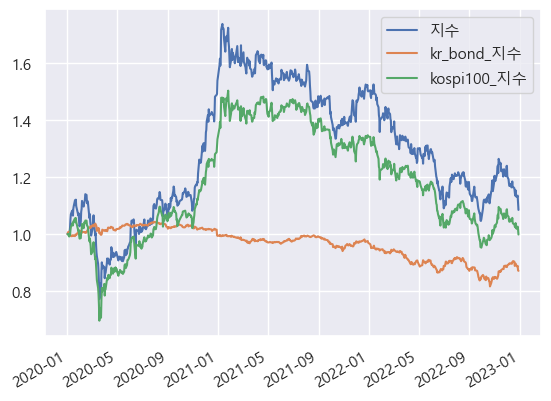

In [16]:
tot_df=pd.merge(right=df[['kr_bond_지수','kospi100_지수']],left=fdf['지수'],left_index=True, right_index=True)
tot_df.plot()
plt.show()

## Sharp index

In [22]:
total=np.log(1+df[['kr_bond','kospi100']])
total.head()

,kr_bond,kospi100
Date,,
2020-01-02,11.722262,10.038936
2020-01-03,11.728287,10.037625
2020-01-06,11.730944,10.030164
2020-01-07,11.724733,10.041117
2020-01-08,11.722870,10.035656


In [23]:
annual_ret = total.mean()   * 252
annual_cov = total.cov() * 252

port_ret     = [] 
port_risk    = [] 
port_weights = [] 
port_sharp   = [] 
stocks = total.columns

for _ in range(20000): 
    weights = np.random.random(len(stocks)) 
    weights = weights / np.sum(weights) 

    #------------------- 수익률, 리스크(편차), 샤프지수 -----------------------
    returns = np.dot(weights, annual_ret) 
    risk    = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 
    sharp   =  returns / risk
    
    port_ret.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights) 
    port_sharp.append(sharp) 
    
    
portfolio = {'Returns': port_ret, 'Risk': port_risk,'Sharp':port_sharp,'weights':port_weights} 
for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights]  # portfolio[s] : s를 키값으로 각각의 weight 값들이 들어감
print(portfolio.keys())

dict_keys(['Returns', 'Risk', 'Sharp', 'weights', 'kr_bond', 'kospi100'])


In [24]:
df = pd.DataFrame(portfolio) 
df.head()

,Returns,Risk,Sharp,weights,kr_bond,kospi100
0,2830.861955,1.020067,2775.171748,"[0.6976606417170649, 0.3023393582829351]",0.697661,0.302339
1,2855.242695,0.940947,3034.435555,"[0.7623376010664175, 0.2376623989335826]",0.762338,0.237662
2,2911.743866,0.880448,3307.116801,"[0.9122232825178235, 0.08777671748217647]",0.912223,0.087777
3,2719.664120,1.603392,1696.193941,"[0.4026762538745368, 0.5973237461254632]",0.402676,0.597324
4,2633.419197,2.164950,1216.388267,"[0.173886674817613, 0.826113325182387]",0.173887,0.826113


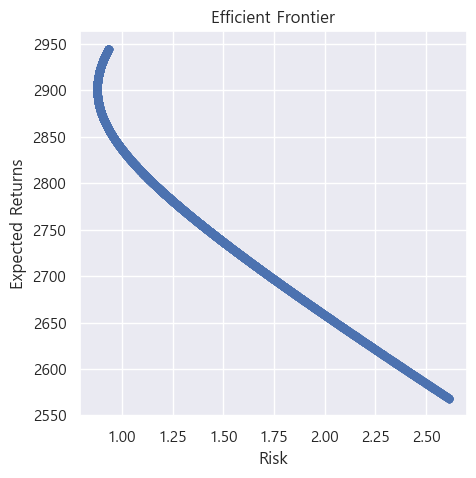

In [26]:
df.plot.scatter(x='Risk', y='Returns', figsize=(5, 5), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 

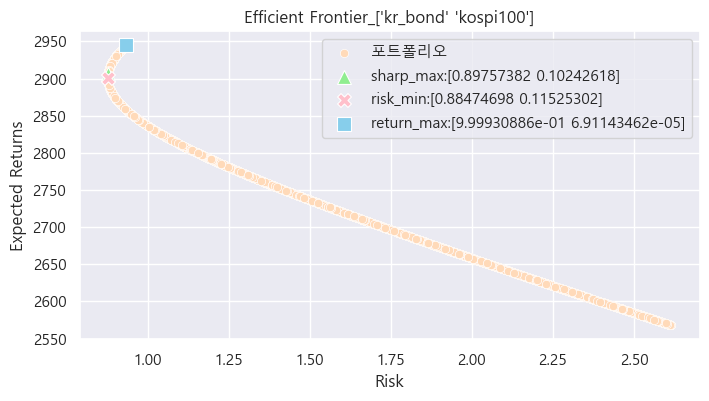

In [27]:
# 샤프치수   최대 포트
sharp_max = df[df['Sharp'] == df['Sharp'].max()]
# 위험리스크 최소 포트
risk_min  = df[df['Risk'] == df['Risk'].min()] 
# 수익률     최대 포트
return_max = df[df['Returns'] == df['Returns'].max()] 

plt.figure(figsize=(8,4))
sns.scatterplot(data=df        , x='Risk', y='Returns' ,color='peachpuff'                 , label=f"포트폴리오") # palevioletred 
sns.scatterplot(data=sharp_max , x='Risk', y='Returns', marker="^", c='lightgreen',s=100, label=f"sharp_max:{sharp_max['weights'].values[0]}")
sns.scatterplot(data=risk_min  , x='Risk', y='Returns', marker="X", c='pink',s=100, label=f"risk_min:{risk_min['weights'].values[0]}")
sns.scatterplot(data=return_max, x='Risk', y='Returns', marker="s", c='skyblue',s=100, label=f"return_max:{return_max['weights'].values[0]}")

plt.title(f'Efficient Frontier_{stocks.values}') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 